In [ ]:
# let's make this a clean file where we just compare xmls and csvs.


In [ ]:
# let's make a csv reader
# This is the same on both voltage and current

# this is really tough because now we have multiple times:
# We deal with dictionaries of a single phase in the input to plots so we can just say each csv file deals with one phase. 
# all we have to do is have a function that takes in a csv and then spits out a dict of dictionaries, each one holding
# a different timeframe 
# we have csv reader code somewhere out there. Look into this: 
# make it as flexible as possible. 
# what I could do is make seperate folders, link_A, link_B, and link_C, and assume it gives me time-series data on 
# all the links of the power system, and then it compiles it all together. 

import sys, csv
import numpy as np
import cmath
from datetime import datetime
import dateutil.parser

def value_to_complex(val):
    return complex(val[0:-1] + 'j')


def parse_csv(my_csv):
#     returns list of dictionaries
    with open(my_csv) as csvfile:
        csv_reader = csv.reader(csvfile)
        fieldnames = []
        main_lst = []
#         so here we get our column names 
        for row in csv_reader:
            if (len(row) > 1 and fieldnames == []):
                fieldnames = row
                break
        csv_dictreader = csv.DictReader(csvfile,fieldnames)
        for row in csv_dictreader:
            new_dict_volt = {}
            new_dict_deg = {}
            for i in range(1,len(row)):
                row_value = cmath.polar(value_to_complex(row[fieldnames[i]]))
                new_dict_volt[fieldnames[i]] = row_value[0]
                new_dict_deg[fieldnames[i]] = row_value[1] * 180 / cmath.pi 
            main_lst.append([new_dict_volt, new_dict_deg])
    return main_lst

# for now this deals with time
def parse_csv_column(my_csv, cname):
    #     returns dictionary with timesteps as keys
    with open(my_csv) as csvfile:
        csv_reader = csv.reader(csvfile)
        fieldnames = []
#         so here we get our column names 
        for row in csv_reader:
            if (len(row) > 1 and fieldnames == []):
                fieldnames = row
                break
        csv_dictreader = csv.DictReader(csvfile,fieldnames)
        new_dict_volt = {}
        new_dict_deg = {}
        for row in csv_dictreader:
            if (cname not in row):
                print(cname+' not in row')
                print('you will get blank dicts')
                return {}, {}
            row_value = cmath.polar(value_to_complex(row[cname]))
            time_value = dateutil.parser.parse(row[fieldnames[0]])
            new_dict_volt[time_value.time().strftime('%H')] = row_value[0]
            new_dict_deg[time_value.time().strftime('%H')] = row_value[1] * 180 / cmath.pi 
    return new_dict_volt, new_dict_deg
            

In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def make_meter_dicts(meter_lst, attr_lst):
    ret_lst = []
    for a in attr_lst:
        ret_lst.append({})
    for m in meter_lst:
        if m.tag == "inherits_from":
            continue
        mname = m.find('name').text
#         The function on what do we do with our data
        for i in range(0,len(attr_lst)):
            ret_lst[i][mname] = m.find(attr_lst[i]).text
    return ret_lst

def mv_dict_gen(meter_lst):
    return make_meter_dicts(meter_lst, ['measured_voltage_A', 'measured_voltage_B', 'measured_voltage_C'])
# we can use this function to try to get different phases

def meter_phase_dict(meter_lst):
    ret_lst = []
    phase_dict = {}
    phase_dict['A'] = []
    phase_dict['B'] = []
    phase_dict['C'] = []
    phase_dict['D'] = []
    phase_dict['G'] = []
    phase_dict['N'] = []
    phase_dict['S'] = []
    for m in meter_lst:
        if m.tag == "inherits_from":
            continue
        mname = m.find('name').text
#         The function on what do we do with our data
        mphases = list(m.find("phases").text)
        for p in mphases:
            phase_dict[p].append(mname)
    return phase_dict

def get_meter_info(my_xml):
    tree = ET.parse(my_xml)
    root = tree.getroot()
    powerflow = None
    meter_lst = None
    for r in root:
    #     print(r.tag)
        if r.tag == "powerflow":
            powerflow = r
    for p in powerflow:
    #     print(p.tag)
        if p.tag == "meter_list":
            meter_lst = p
#     where the meter_lst parse function is
    
    return meter_phase_dict(meter_lst)


def remove_zeros_from_dict(my_dict):
    cp_dict = my_dict.copy()
    my_keys = my_dict.keys()
    for k in my_keys:
        if cp_dict[k] == 0.0:
            del cp_dict[k]
    return cp_dict

In [ ]:
# how do we deal with the transformer without taking it out of relevance? Ask this later to the professor. 
def add_axes_data(ax, y_lines_lst, y_lines_lbls, lbl_lst, y_label, phase,mname_lst):
    if (len(y_lines_lst) < 1 or len(y_lines_lst) != len(y_lines_lbls)):
        return
    a_lst = y_lines_lst[0]
    x = range(1,len(a_lst) + 1)
    ax.xaxis.set_ticks(x)
    ax.set_xticklabels(lbl_lst)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_xlabel('Meters, closest to farthest from {0}'.format(mname_lst[0]))
    ax.set_ylabel(y_label)
    ax.set_title('Phase {1} {0} of Meters in IEEE 13 node feeder'.format(y_label, phase))
    for y,y_lbl in zip( y_lines_lst, y_lines_lbls):
        y_line = ax.scatter(x, y ,label=y_lbl)
    ax.legend()

    gridlines = []
    ticklines = []
    ax.grid(True)
    gridlines += ax.get_xgridlines() + ax.get_ygridlines()
    ticklines += ax.get_xticklines() + ax.get_yticklines()
    for line, l2 in zip(gridlines,ticklines):
        line.set_linestyle('-.')
        l2.set_linewidth(3)
        
# you want to remove entries that are not in phase, you can have this built into the function
# cause when will you want data from a meter with no data? 
# we won't try to use ex_lst when we deal with the inverter voltage vs time graph
def give_lsts_and_lbls(dict1, dict2, mname_lst, unit_val, min_val=-10000, ex_lst=None):
#     we want to copy the list, since we will be deleting from the copy list
    
    if ex_lst:
        name_lst = []
        for m in mname_lst:
            if m in ex_lst:
                name_lst.append(m)
    else:
        name_lst = mname_lst[:]
    f_lst_p = [(i , dict1[i] / unit_val) for i in name_lst if dict1[i] / unit_val > min_val]
    g_lst_p = [(i , dict2[i] / unit_val) for i in name_lst if dict2[i] / unit_val > min_val]
    lbl_lst = [f[0] for f in f_lst_p]
    f_lst = [f[1] for f in f_lst_p]
    g_lst = [g[1] for g in g_lst_p]
    return f_lst, g_lst, lbl_lst

# what if we just have a function that takes in two dictionaries, and then we print the errors. 
# technically this is a four dict plot and it generates 9 to 15 plots. 
def four_dict_plt(a_dict_lst, b_dict_lst, c_dict_lst, d_dict_lst,
                 mname_lst=None, toggle_error=True, ylabel1='Voltage (V)',ylabel2='Angle',
                 filename='voltage',l1_name='base', l2_name='test', pu_volt=2401.7771, phase_xml=None ):
#     initialization
    if (pu_volt):
        m_fig, ax_lst = plt.subplots(3,3, figsize=(10,10))
        m_fig.set_size_inches(20,15)
        pu_index = 1
        ang_index = 2
    else:
        m_fig, ax_lst = plt.subplots(2,3, figsize=(10,10))
        m_fig.set_size_inches(20,10)
        pu_index = 2
        ang_index = 1
    if (toggle_error):
        e_fig, e_lst = plt.subplots(2,3, figsize=(10,10))
        e_fig.set_size_inches(20,10)
    plt.figure(figsize=(12,12))
    
#     so this does it for every phase, but we need to grab a mname lst for each 
    for a_dict, b_dict, c_dict, d_dict, letter, i in zip(a_dict_lst,b_dict_lst,c_dict_lst, d_dict_lst,
                                                         ('A','B','C'), (int(0),int(1),int(2))):
        if (mname_lst == None):
            mname_lst = sorted(list(a_dict.keys()))
        ex_lst = None
        if (phase_xml):
            ex_lst = get_meter_info(phase_xml)[letter]
        phase = letter
        y_label = ylabel1
        a_lst, b_lst, lbl_lst_1 = give_lsts_and_lbls(a_dict, b_dict, mname_lst, 1,ex_lst=ex_lst)
        err_lst = [ abs(b-a)/ a * 100 if (a != 0) else 0.0 for a,b in zip(a_lst, b_lst)]
        add_axes_data(ax_lst[0][i], [a_lst, b_lst],[l1_name, l2_name], lbl_lst_1, y_label, phase, mname_lst)
        if (toggle_error):
            add_axes_data(e_lst[0][i], [err_lst],['error'], mname_lst, 'error %', phase) 
        y_label = ylabel2
        c_lst, d_lst, lbl_lst_2 = give_lsts_and_lbls(c_dict, d_dict, lbl_lst_1, 1,ex_lst=ex_lst)
        err_lst = [ b-a for a,b in zip(c_lst, d_lst)]
        add_axes_data(ax_lst[ang_index][i], [c_lst, d_lst],[l1_name, l2_name], lbl_lst_2, y_label, phase, mname_lst)
        if (toggle_error):
            add_axes_data(e_lst[1][i], [err_lst],['error'], mname_lst, 'error degree diff', phase, mname_lst) 
        
            
# now make set of graphs for p.u. 
    if pu_volt:
        for a_dict, b_dict, letter, i in zip(a_dict_lst,b_dict_lst, ('A','B','C'), (int(0),int(1),int(2))):
            if (mname_lst == None):
                mname_lst = sorted(list(a_dict.keys()))
            ex_lst = None
            if (phase_xml):
                ex_lst = get_meter_info(phase_xml)[letter]
            phase = letter
            y_label = ylabel1 + "(p.u.)"
            f_lst, g_lst, lbl_lst_3 = give_lsts_and_lbls(a_dict, b_dict, mname_lst, pu_volt, ex_lst=ex_lst)
            add_axes_data(ax_lst[pu_index][i], [f_lst, g_lst],[l1_name, l2_name], lbl_lst_3, y_label, phase, mname_lst)      
            
    m_fig.tight_layout()
    m_fig.savefig('cmpIEEE13plts/' + filename)
    if (toggle_error):
        e_fig.tight_layout() 
        e_fig.savefig('cmpIEEE13plts/' + filename + '_error')
    plt.show()
    return None


In [ ]:
# make this a lot cleaner
def compare_gridlab_csv(csv_lst_1, csv_lst_2, ylabel1, ylabel2,filename,
                        timestep, phase_xml, mname_lst, pu_volt, toggle_error):
#     This is all the meters in order of farthest from m650, the slack bus, but we will exclude m634 because of transformer
#     don't know how to deal with it yet. m634 is in between m671 and m646
    dict_A_mag_1, dict_A_ang_1 = parse_csv(csv_lst_1[0])[timestep]
    dict_B_mag_1, dict_B_ang_1 = parse_csv(csv_lst_1[1])[timestep]
    dict_C_mag_1, dict_C_ang_1 = parse_csv(csv_lst_1[2])[timestep]
    dict_A_mag_2, dict_A_ang_2 = parse_csv(csv_lst_2[0])[timestep]
    dict_B_mag_2, dict_B_ang_2 = parse_csv(csv_lst_2[1])[timestep]
    dict_C_mag_2, dict_C_ang_2 = parse_csv(csv_lst_2[2])[timestep]
    a_dict_lst = [dict_A_mag_1, dict_B_mag_1, dict_C_mag_1]
    b_dict_lst = [dict_A_mag_2, dict_B_mag_2, dict_C_mag_2]
    c_dict_lst = [dict_A_ang_1, dict_B_ang_1, dict_C_ang_1]
    d_dict_lst = [dict_A_ang_2, dict_B_ang_2, dict_C_ang_2]
    four_dict_plt(a_dict_lst, b_dict_lst, c_dict_lst, d_dict_lst, mname_lst,
                 ylabel1=ylabel1, ylabel2=ylabel2,filename=filename+'_'+str(timestep),
                 pu_volt=pu_volt, phase_xml=phase_xml, toggle_error=toggle_error)

def compare_gridlab_csv_voltage(csv_lst_1, csv_lst_2, ylabel1='Voltage (V)', ylabel2='Angle',filename='Voltage',
                                timestep=-1, phase_xml=None, mname_lst=None, pu_volt=2401.7771, toggle_error=True):
#     This is all the meters in order of farthest from m650, the slack bus, but we will exclude m634 because of transformer
#     don't know how to deal with it yet. m634 is in between m671 and m646
    if (mname_lst == None):
        mname_lst = ['m650',
        'm632',
        'm633',
        'm645',
        'm671',
        'm646',
        'm680',
        'm684',
        'm692',
        'm611',
        'm652',
        'm675']
    compare_gridlab_csv(csv_lst_1, csv_lst_2, ylabel1, ylabel2,
                        filename, timestep, phase_xml, mname_lst, pu_volt, toggle_error)
    
def compare_gridlab_csv_current(csv_lst_1, csv_lst_2, ylabel1='Current (A)', ylabel2='Angle', filename='Current',
                                timestep=-1, phase_xml=None, mname_lst=None, pu_volt=None, toggle_error=True):
#     This is all the meters in order of farthest from m650, the slack bus, but we will exclude m634 because of transformer
#     don't know how to deal with it yet. m634 is in between m671 and m646
    if (mname_lst == None):
        mname_lst = ['m650',
        'm632',
        'm633',
        'm645',
        'm671',
        'm646',
        'm680',
        'm684',
        'm692',
        'm611',
        'm652',
        ]
    compare_gridlab_csv(csv_lst_1, csv_lst_2, ylabel1, ylabel2,
                        filename, timestep, phase_xml, mname_lst, pu_volt, toggle_error)
    


In [ ]:
# now it's time to make graphs out of the inverter vs time.
def compare_inverter_data(csv_lst_1, csv_lst_2, ylabel1, ylabel2,
                          filename, inverter_meter, pu_volt, toggle_error):
#     This is all the meters in order of farthest from m650, the slack bus, but we will exclude m634 because of transformer
#     don't know how to deal with it yet. m634 is in between m671 and m646
    dict_A_mag_1, dict_A_ang_1 = parse_csv_column(csv_lst_1[0], inverter_meter)
    dict_B_mag_1, dict_B_ang_1 = parse_csv_column(csv_lst_1[1], inverter_meter)
    dict_C_mag_1, dict_C_ang_1 = parse_csv_column(csv_lst_1[2], inverter_meter)
    dict_A_mag_2, dict_A_ang_2 = parse_csv_column(csv_lst_2[0], inverter_meter)
    dict_B_mag_2, dict_B_ang_2 = parse_csv_column(csv_lst_2[1], inverter_meter)
    dict_C_mag_2, dict_C_ang_2 = parse_csv_column(csv_lst_2[2], inverter_meter)
    a_dict_lst = [dict_A_mag_1, dict_B_mag_1, dict_C_mag_1]
    b_dict_lst = [dict_A_mag_2, dict_B_mag_2, dict_C_mag_2]
    c_dict_lst = [dict_A_ang_1, dict_B_ang_1, dict_C_ang_1]
    d_dict_lst = [dict_A_ang_2, dict_B_ang_2, dict_C_ang_2]
    four_dict_plt(a_dict_lst, b_dict_lst, c_dict_lst, d_dict_lst, mname_lst=None,
                 ylabel1=ylabel1, ylabel2=ylabel2, filename=filename, pu_volt=pu_volt, toggle_error=toggle_error)

def compare_inverter_data_voltage(csv_lst_1, csv_lst_2, ylabel1='Voltage (V)', ylabel2='Angle',
                          filename='Voltage', inverter_meter='m680', pu_volt=2401.7771, toggle_error=True):
    return compare_inverter_data(csv_lst_1, csv_lst_2, ylabel1, ylabel2,
                          filename, inverter_meter, pu_volt, toggle_error)

def compare_inverter_data_current(csv_lst_1, csv_lst_2, ylabel1='Current (A)', ylabel2='Angle',
                                filename='Current', inverter_meter='m680', pu_volt=None, toggle_error=True):
    return compare_inverter_data(csv_lst_1, csv_lst_2, ylabel1, ylabel2,
                          filename, inverter_meter, pu_volt, toggle_error)


In [ ]:
# here we get inverter online/offline status

def get_status_int(status_str):
    if (status_str == "ONLINE"):
        return 1
    return -1

# we can use this for time series later
def parse_inverter(my_csv):
#     returns list of dictionaries
    with open(my_csv) as csvfile:
        csv_reader = csv.reader(csvfile)
        fieldnames = []
        main_lst = []
#         so here we get our column names 
        for row in csv_reader:
            if (len(row) > 1 and fieldnames == []):
                fieldnames = row
                break
        csv_dictreader = csv.DictReader(csvfile,fieldnames)
        for row in csv_dictreader:
            new_dict_status = {}
            for i in range(1,len(row)):
#                 we can get time data
                new_dict_status[fieldnames[0]] = row[fieldnames[i]]
            main_lst.append(new_dict_status)
    return main_lst

            
def inverter_status(inverter_csv, ylabel='Inverter-on/off', filename='Inverter_status', timestep=-1):
    inverter_status = parse_inverter(inverter_csv)[timestep]
    with open('cmpIEEE13plts/' + filename + list(inverter_status.keys())[0], 'w') as f:
        f.write('1 is ONLINE, -1 is OFFLINE\n')
        f.write(str(inverter_status))
        print(str(inverter_status))
        
def compare_gridlab_inverter(csv_list,filename, inverter_csv):
    compare_gridlab_IEEE_csv(csv_list,
                         filename=filename)
    inverter_status(inverter_csv)
    
def compare_gridlab_inverter_csv_voltage(csv_lst_1, csv_lst_2,filename,
                                         inverter_csv, timestep=-1, phase_xml=None, toggle_error=True):
    compare_gridlab_csv_voltage(csv_lst_1=csv_lst_1,
                             csv_lst_2=csv_lst_2,
                         filename=filename,
                        timestep=timestep, phase_xml=phase_xml, toggle_error=toggle_error)
    inverter_status(inverter_csv)
def compare_gridlab_inverter_csv_current(csv_lst_1, csv_lst_2,filename,
                                         inverter_csv, timestep=-1, phase_xml=None, toggle_error=True):
    compare_gridlab_csv_current(csv_lst_1=csv_lst_1,
                             csv_lst_2=csv_lst_2,
                         filename=filename,
                        timestep=timestep, phase_xml=phase_xml, toggle_error=toggle_error)
    inverter_status(inverter_csv)

In [ ]:
# compare pv before and after changes

compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv.csv',
                          'time_results/voltageB_pv.csv',
                          'time_results/voltageC_pv.csv'],
                         'Voltage_csv_pv_cmp_2',
                        'time_results/inverter_pv.csv',
                            timestep=12,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)
compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv.csv',
                          'time_results/voltageB_pv.csv',
                          'time_results/voltageC_pv.csv'],
                         'Voltage_csv_pv_cmp_2',
                        'time_results/inverter_pv.csv',
                            timestep=13,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)


compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv.csv',
                      'time_results/measured_current_B_pv.csv',
                      'time_results/measured_current_C_pv.csv'],
                      filename='Current_csv_pv_cmp_2',
                        timestep=12,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)
compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv.csv',
                      'time_results/measured_current_B_pv.csv',
                      'time_results/measured_current_C_pv.csv'],
                      filename='Current_csv_pv_cmp_2',
                        timestep=13,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)

compare_inverter_data_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv.csv',
                          'time_results/voltageB_pv.csv',
                          'time_results/voltageC_pv.csv'],
                         filename='Voltage_inverter_pv_cmp',
                            toggle_error=False)


compare_inverter_data_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv.csv',
                      'time_results/measured_current_B_pv.csv',
                      'time_results/measured_current_C_pv.csv'],
                      filename='Current_inverter_pv_cmp',
                        toggle_error=False)

In [ ]:
# compare pv before and after changes

compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         'Voltage_csv_pv_cmp_3',
                        'time_results/inverter_pv2.csv',
                            timestep=12,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)
compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         'Voltage_csv_pv_cmp_3',
                        'time_results/inverter_pv2.csv',
                            timestep=13,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)


compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_csv_pv_cmp_3',
                        timestep=12,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)
compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_csv_pv_cmp_3',
                        timestep=13,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)

compare_inverter_data_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         filename='Voltage_inverter_pv_cmp3',
                            toggle_error=False)


compare_inverter_data_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_inverter_pv_cmp3',
                        toggle_error=False)

# compare pv before and after changes

compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         'Voltage_csv_pv_cmp_4',
                        'time_results/inverter_pv2.csv',
                            timestep=12,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         'Voltage_csv_pv_cmp_4',
                        'time_results/inverter_pv2.csv',
                            timestep=13,
                            phase_xml='IEEE13_pv1.xml', toggle_error=False)


compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_csv_pv_cmp_4',
                        timestep=12,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_csv_pv_cmp_4',
                        timestep=13,
                        phase_xml="IEEE13_pv1.xml", toggle_error=False)

compare_inverter_data_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                        ['time_results/voltageA_pv2.csv',
                          'time_results/voltageB_pv2.csv',
                          'time_results/voltageC_pv2.csv'],
                         filename='Voltage_inverter_pv_cmp_4',
                            toggle_error=False)


compare_inverter_data_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv2.csv',
                      'time_results/measured_current_B_pv2.csv',
                      'time_results/measured_current_C_pv2.csv'],
                      filename='Current_inverter_pv_cmp_4',
                        toggle_error=False)

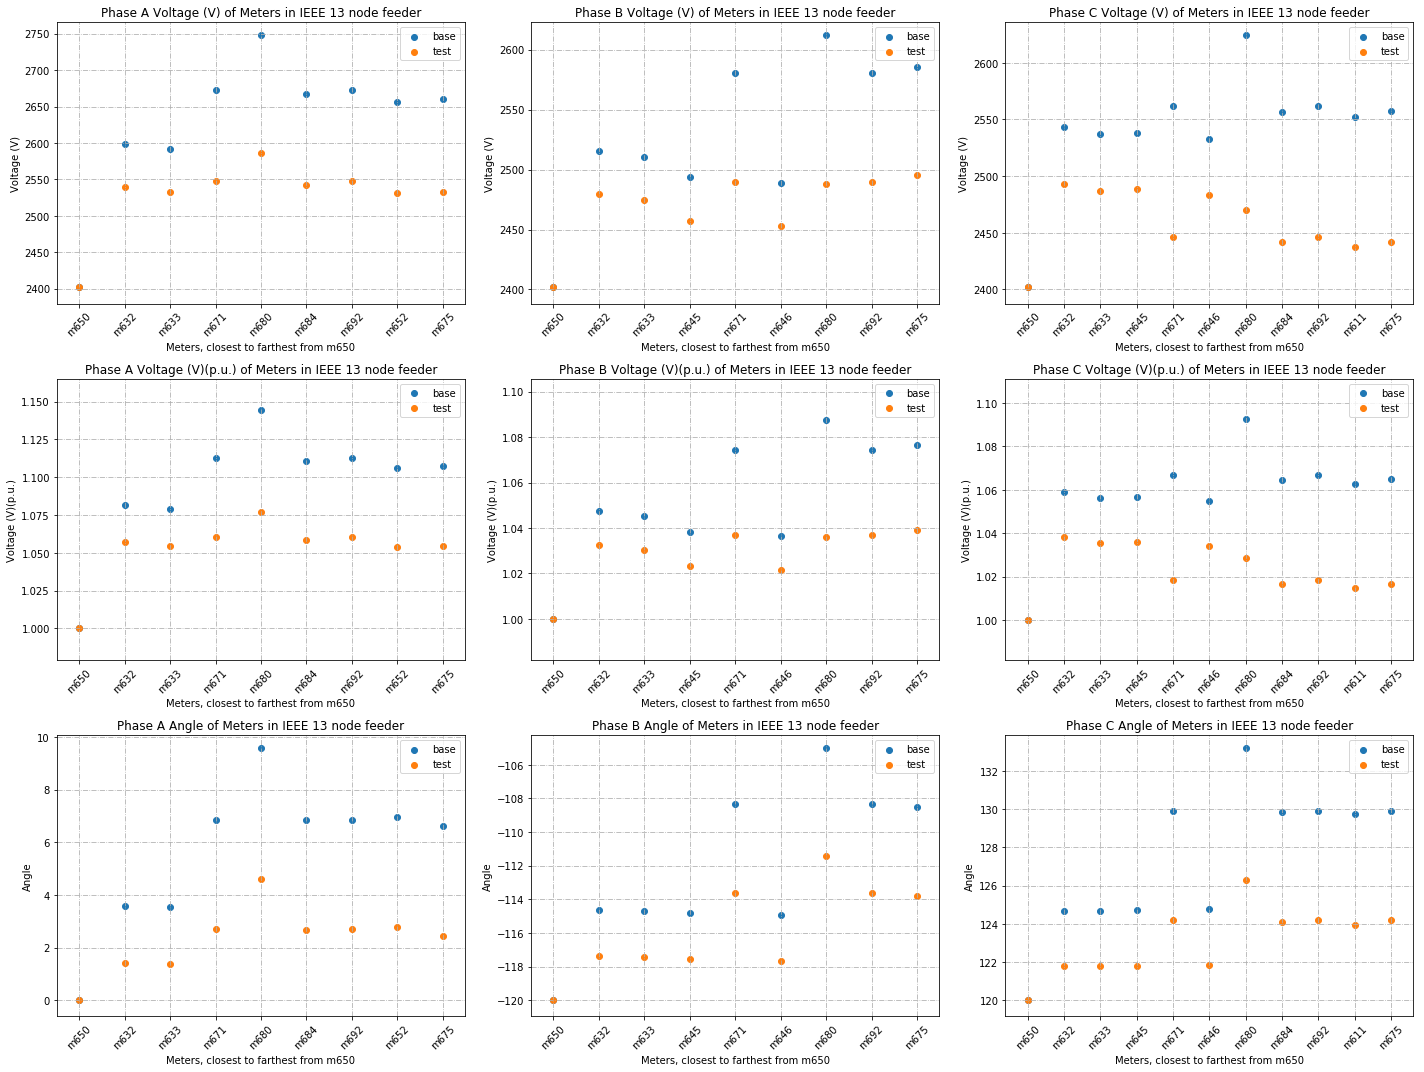

{'# timestamp': 'ONLINE'}


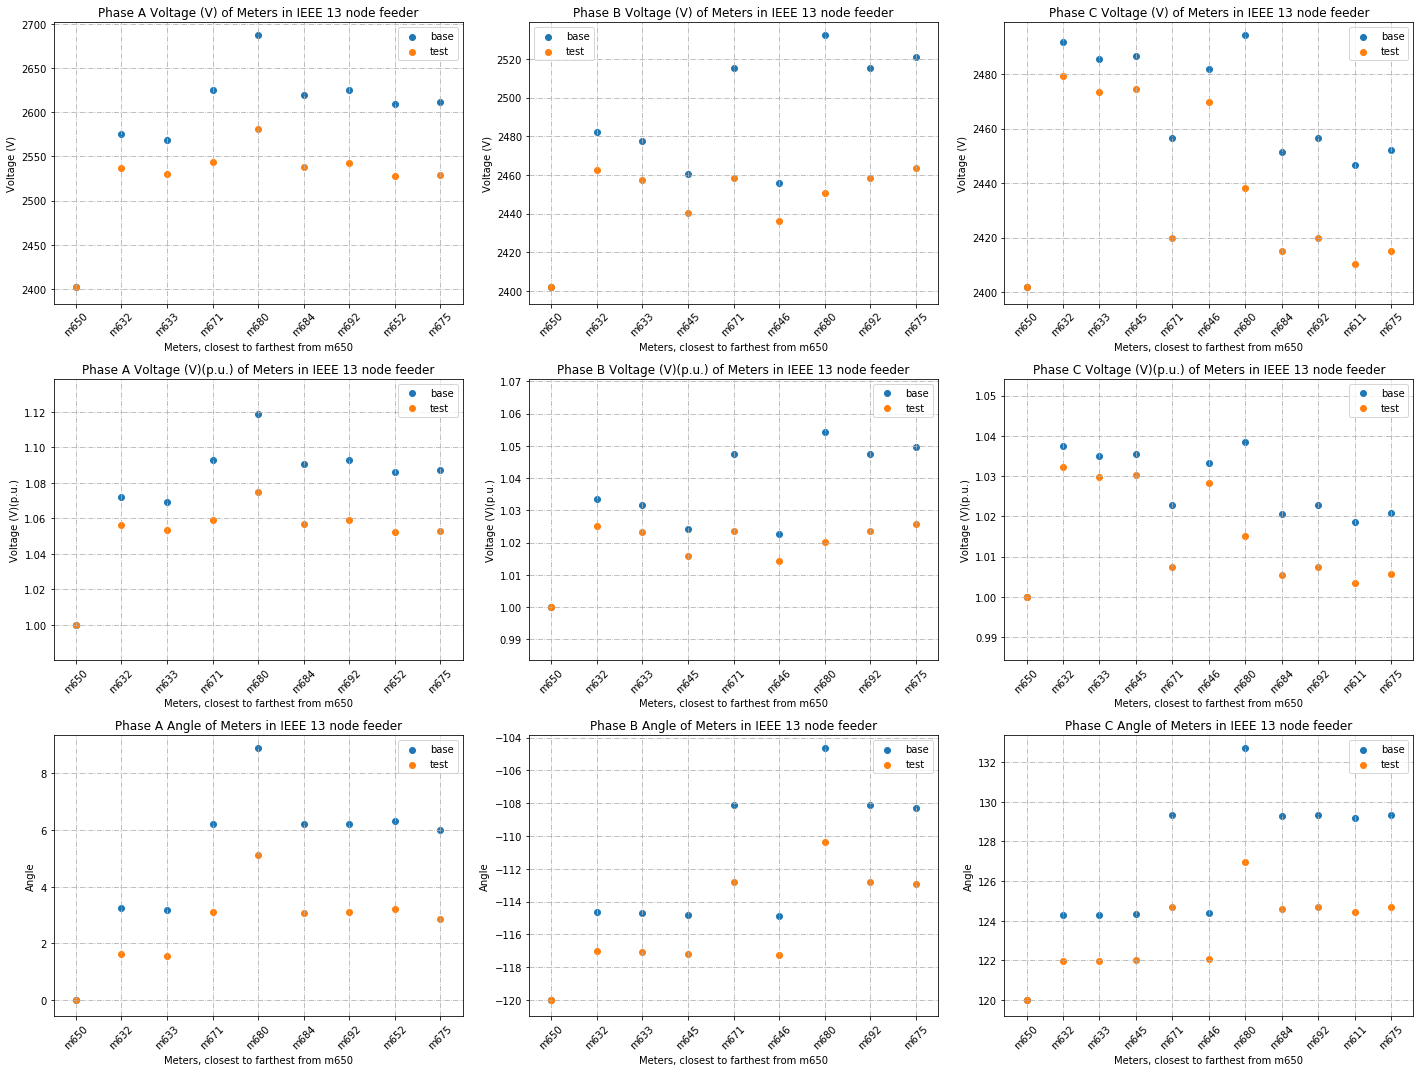

{'# timestamp': 'ONLINE'}


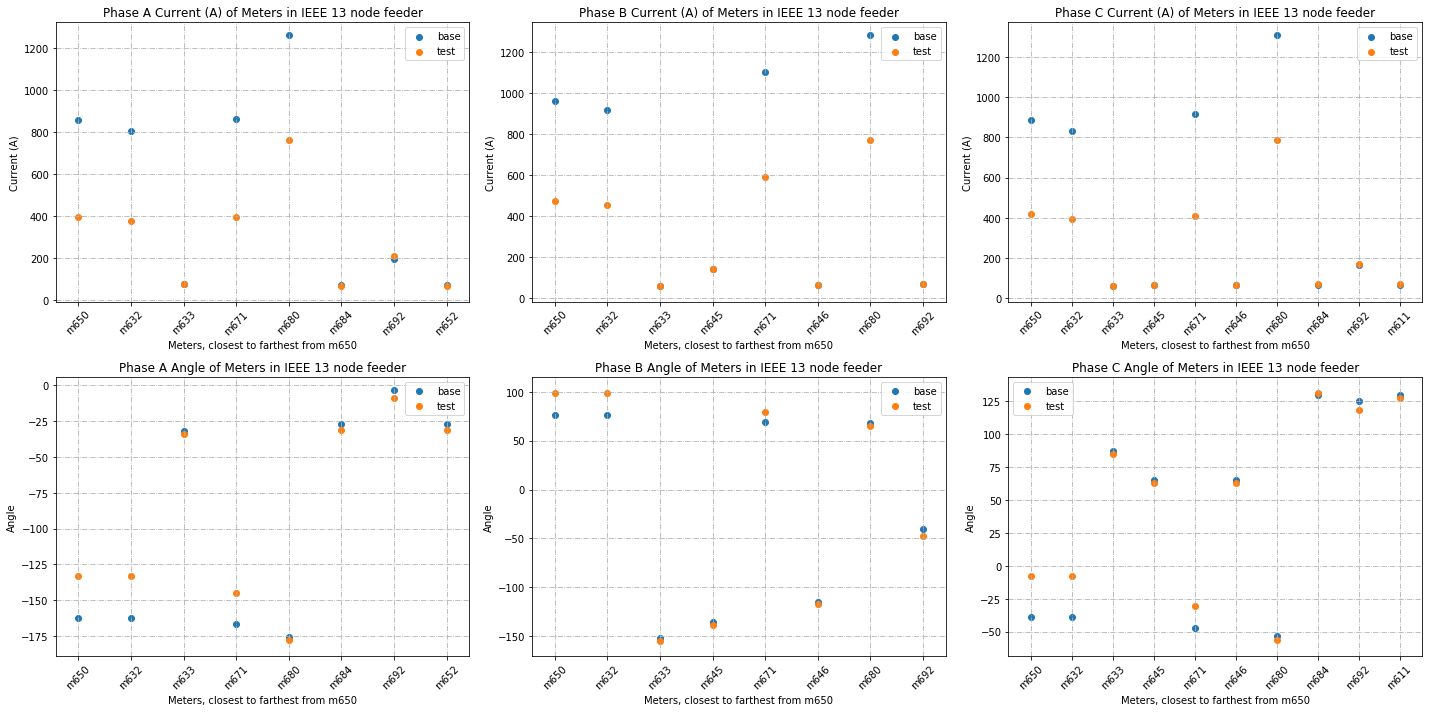

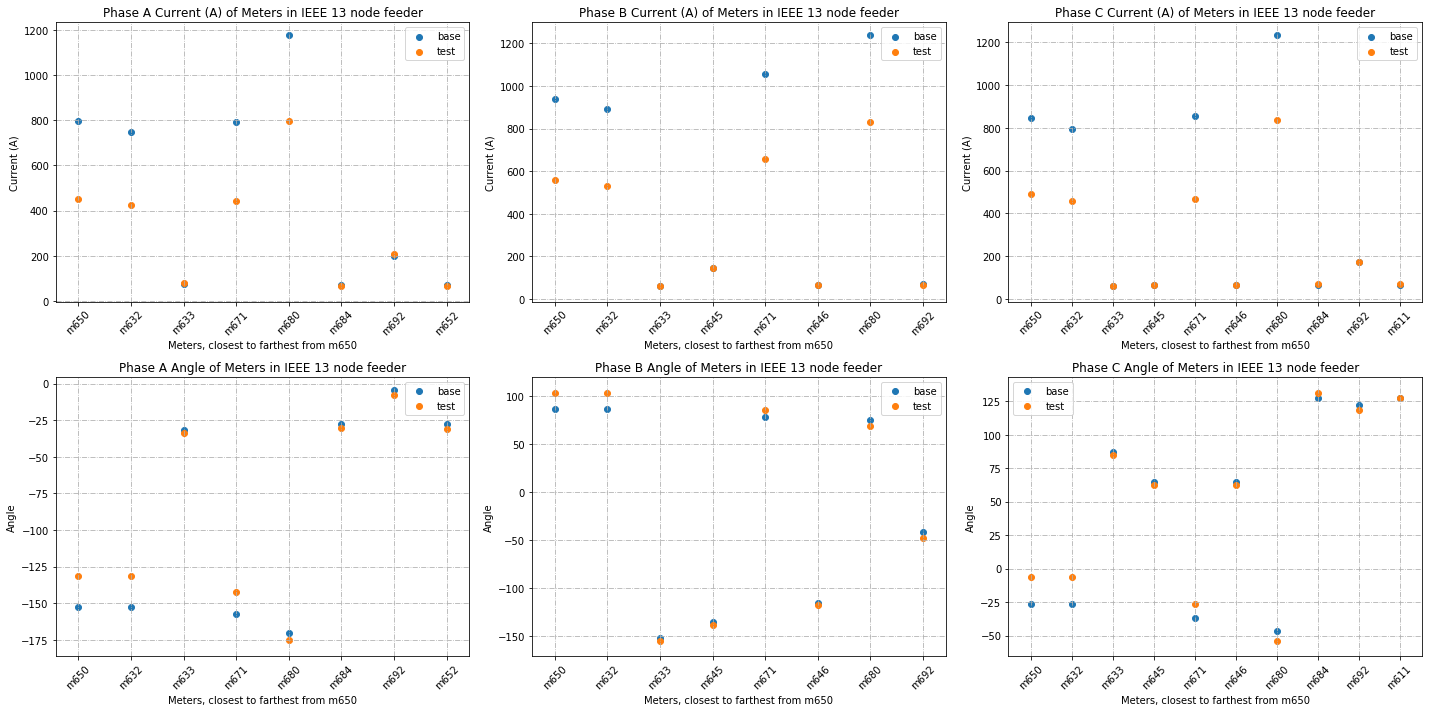

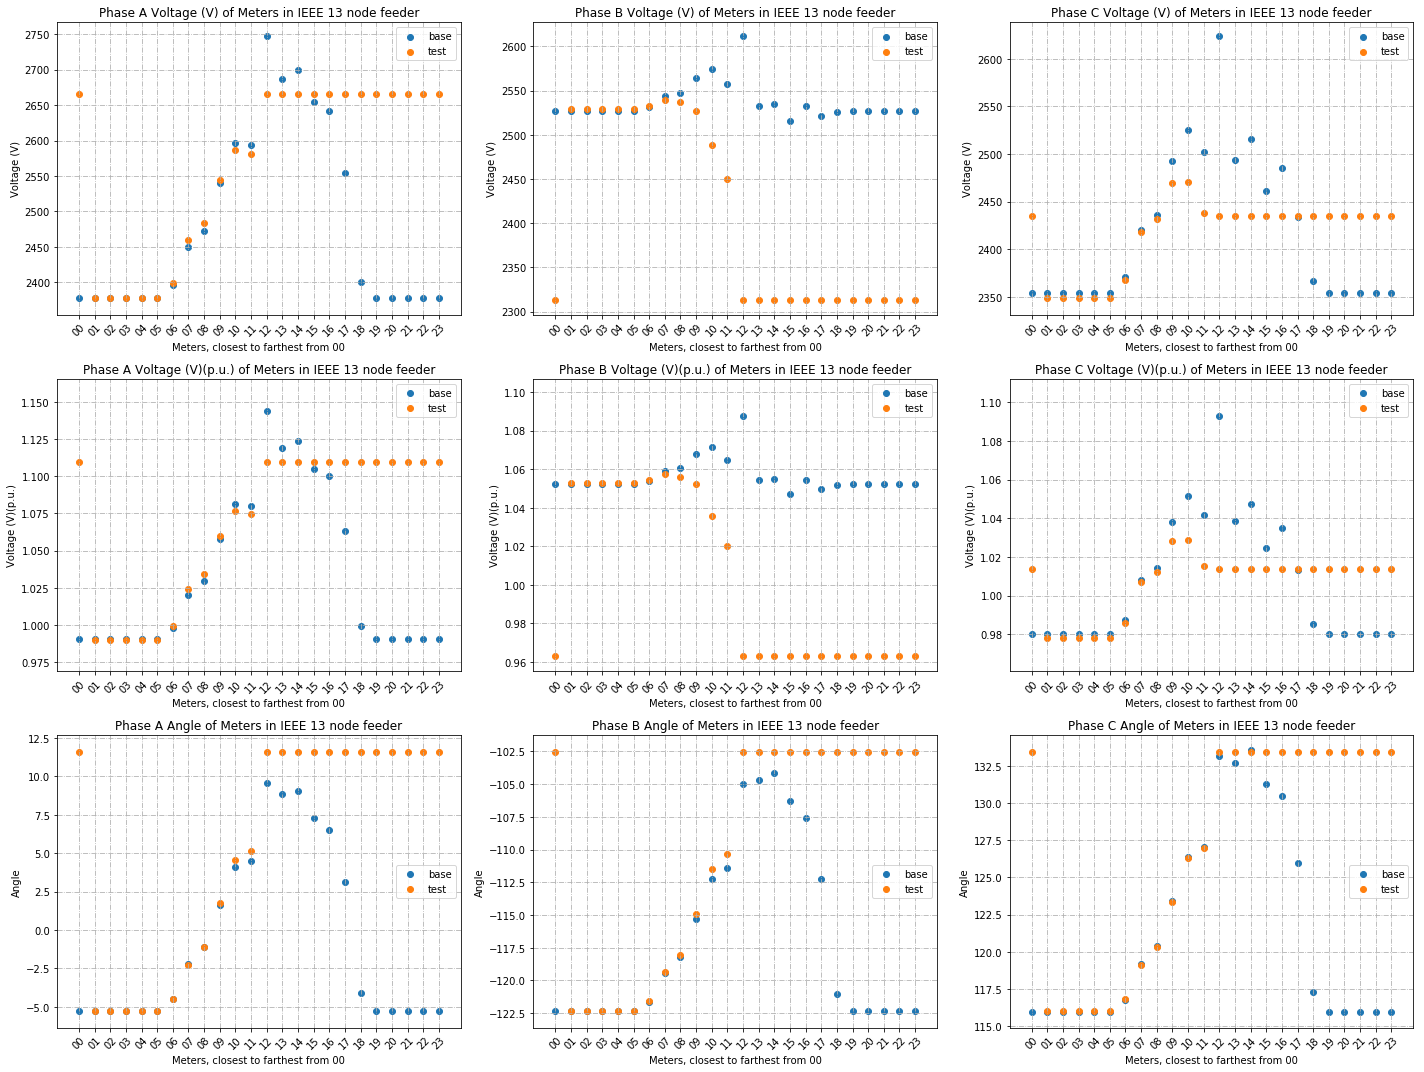

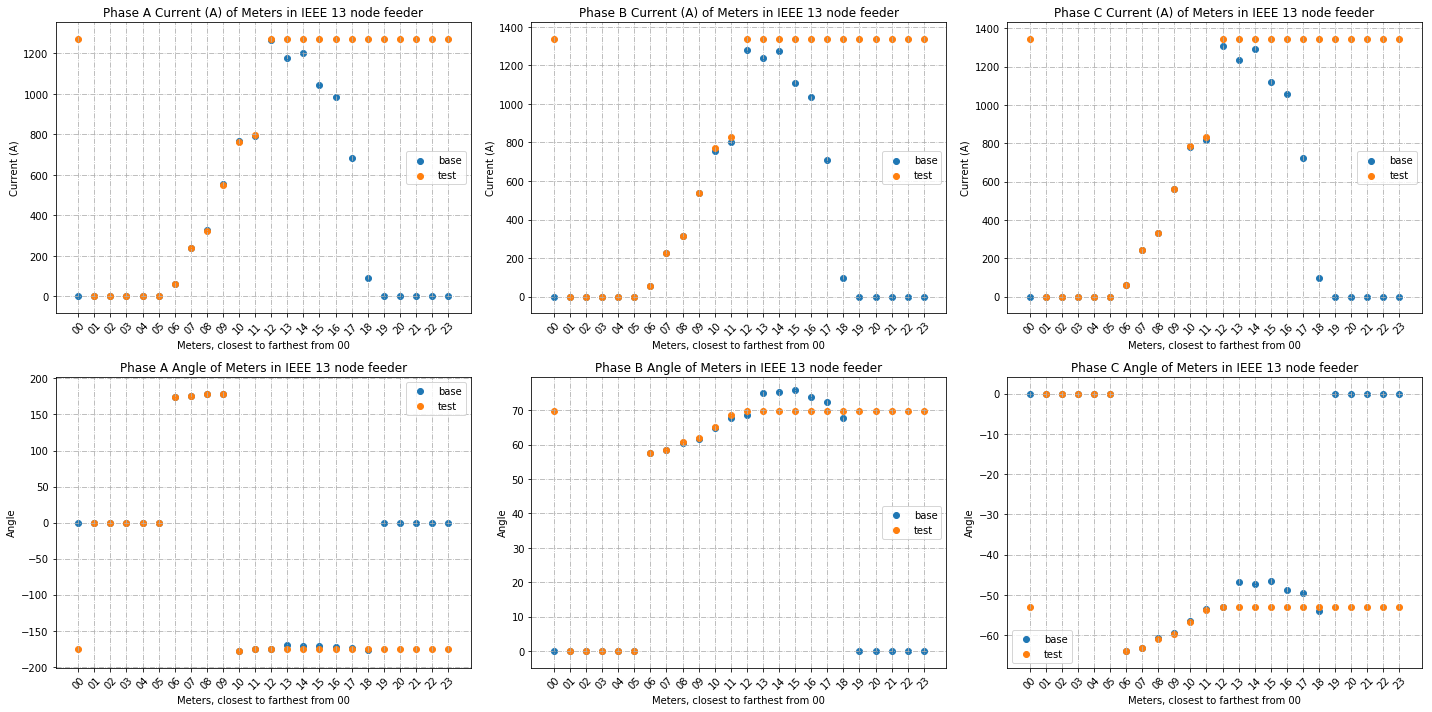

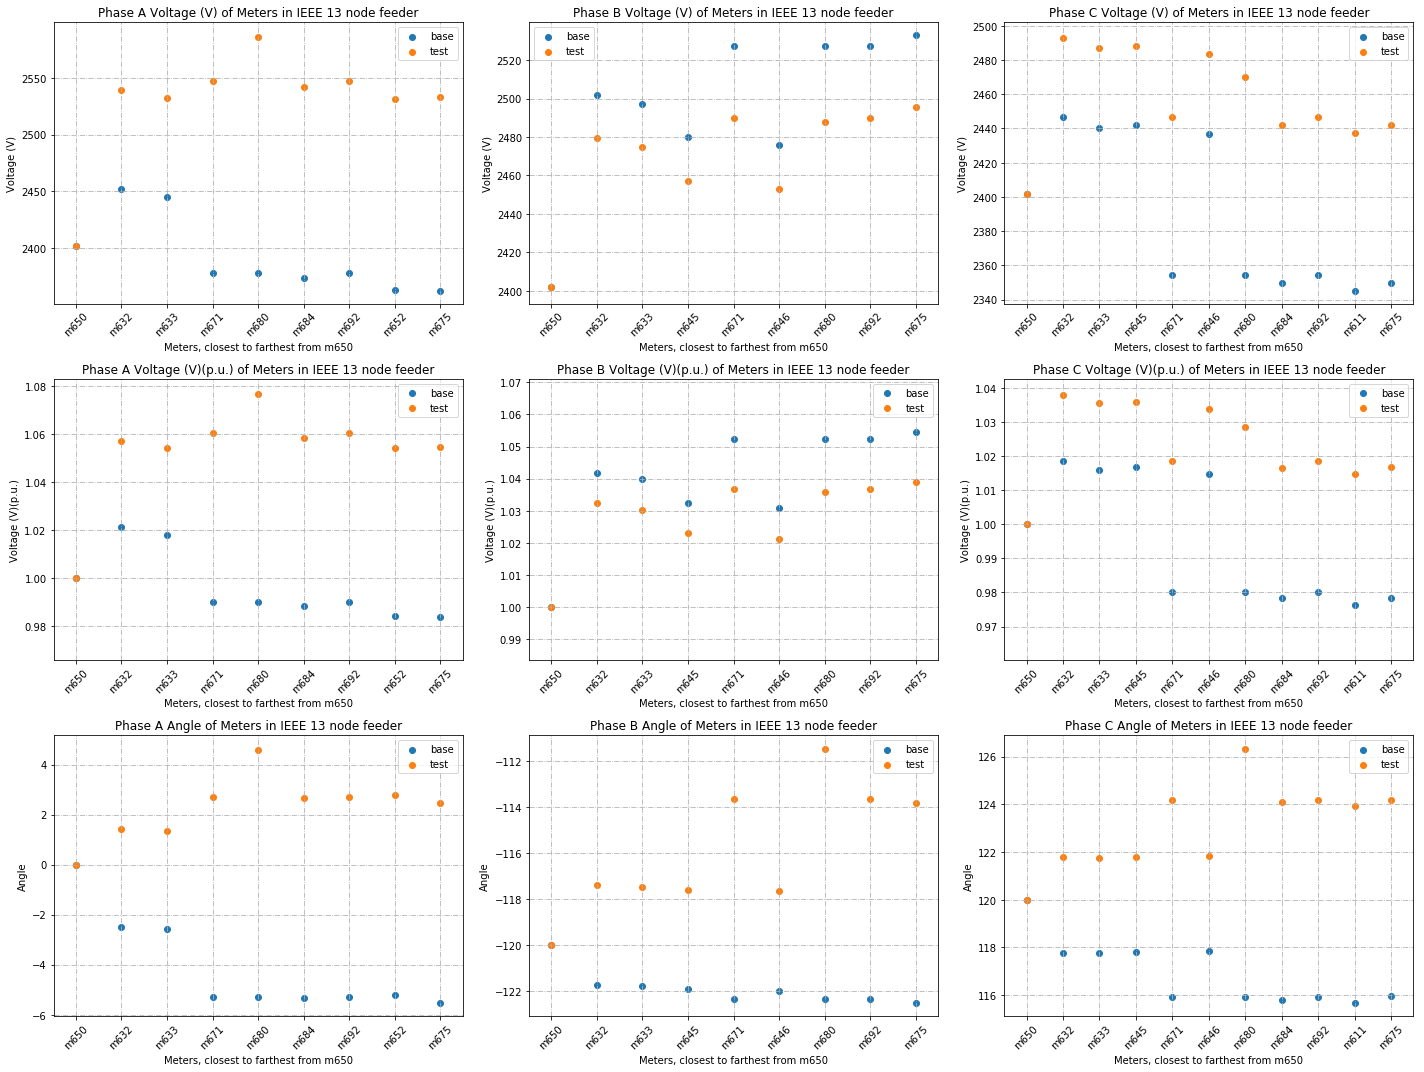

{'# timestamp': 'ONLINE'}


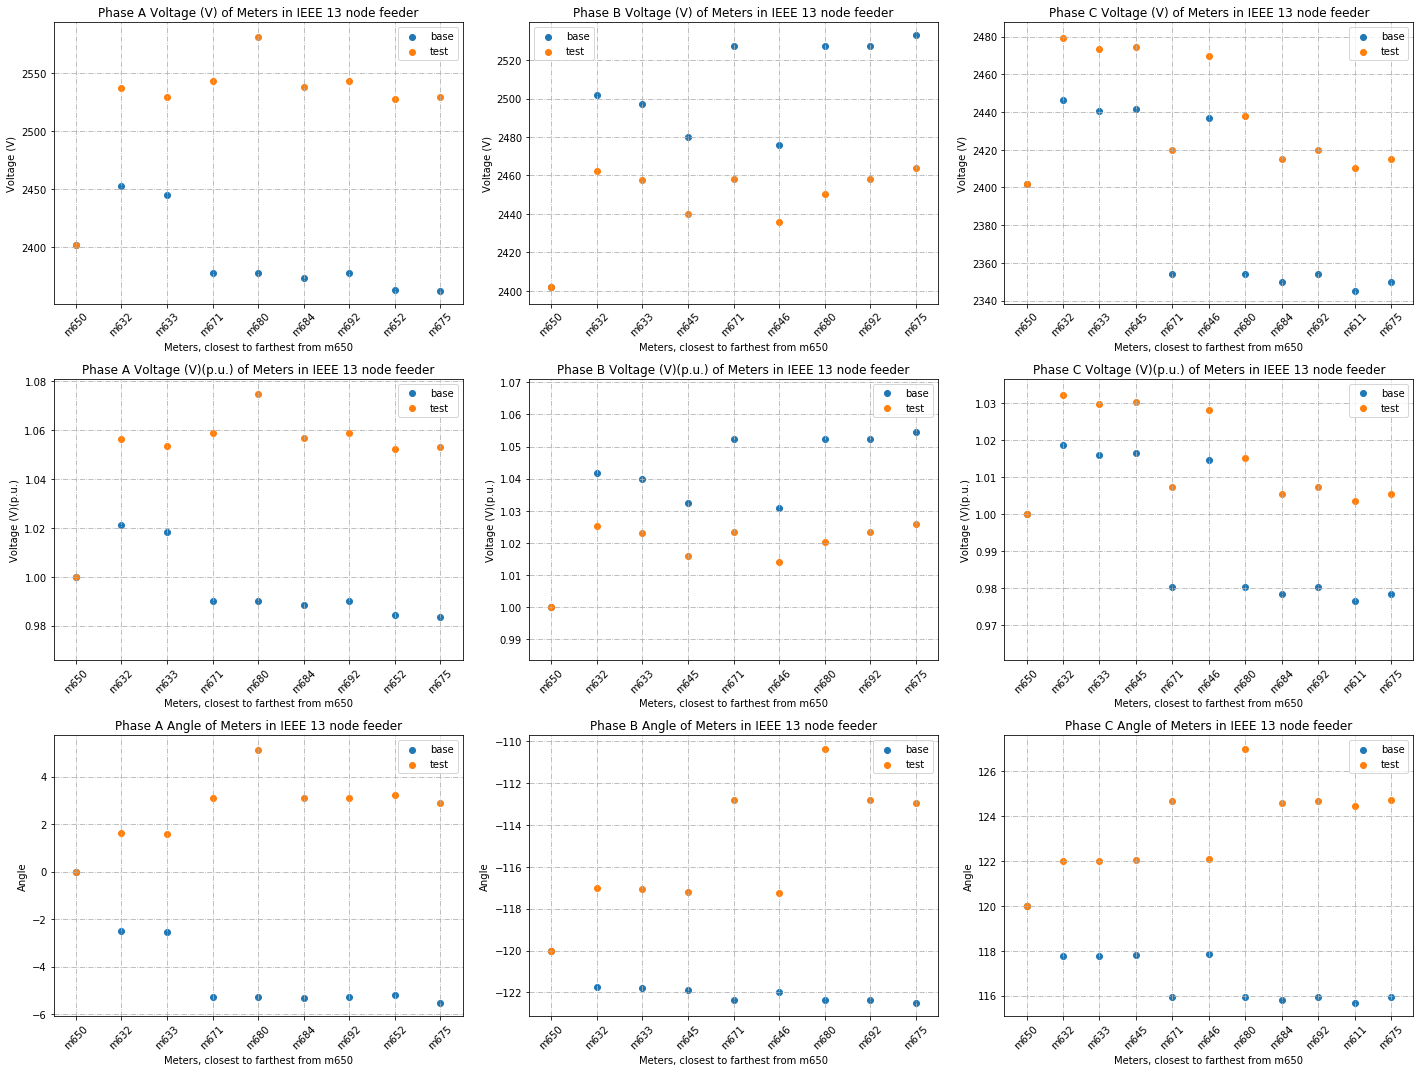

{'# timestamp': 'ONLINE'}


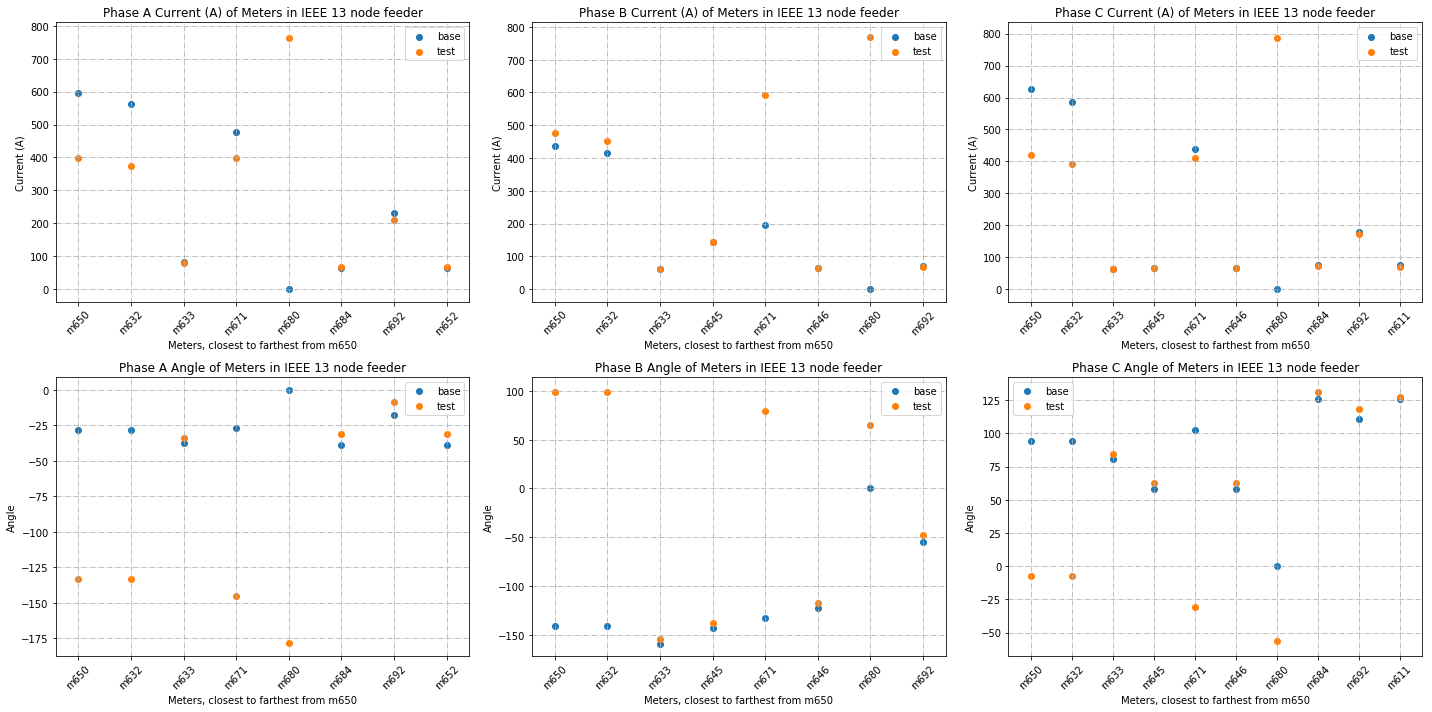

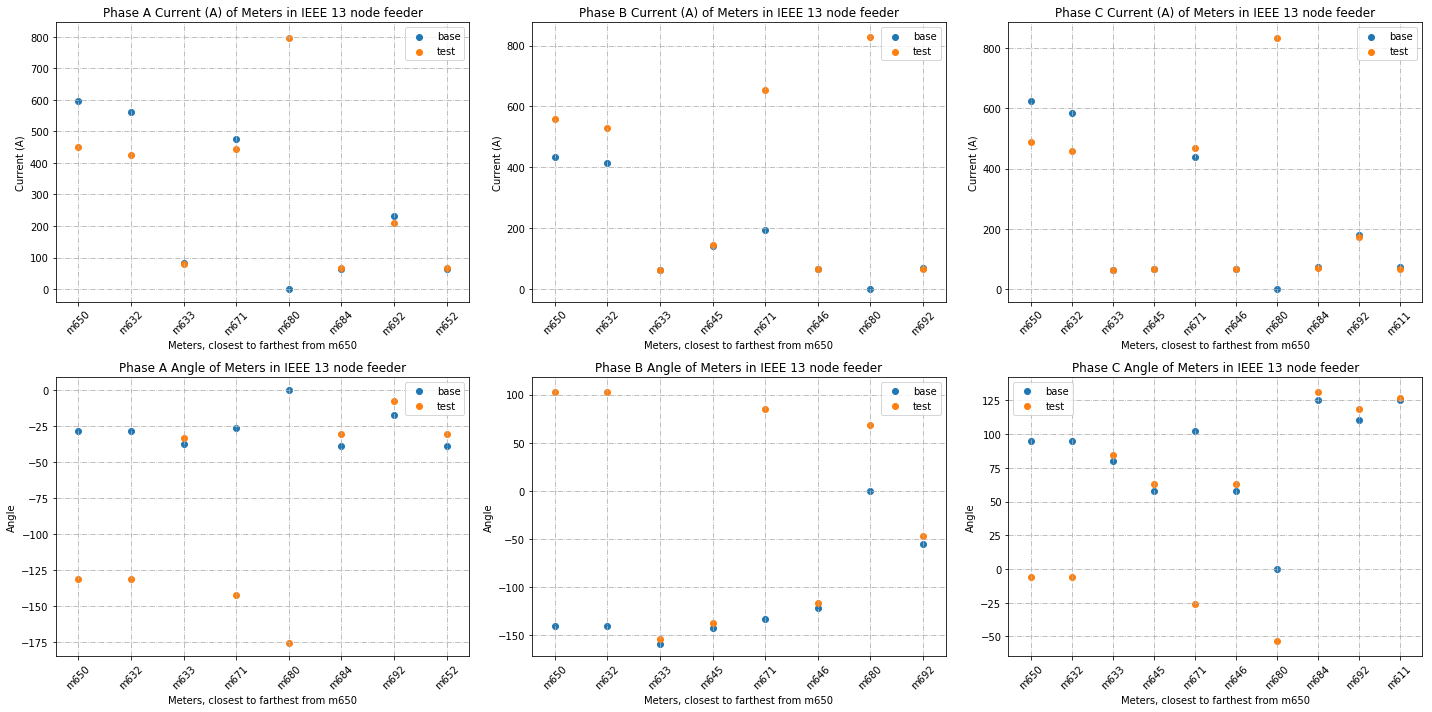

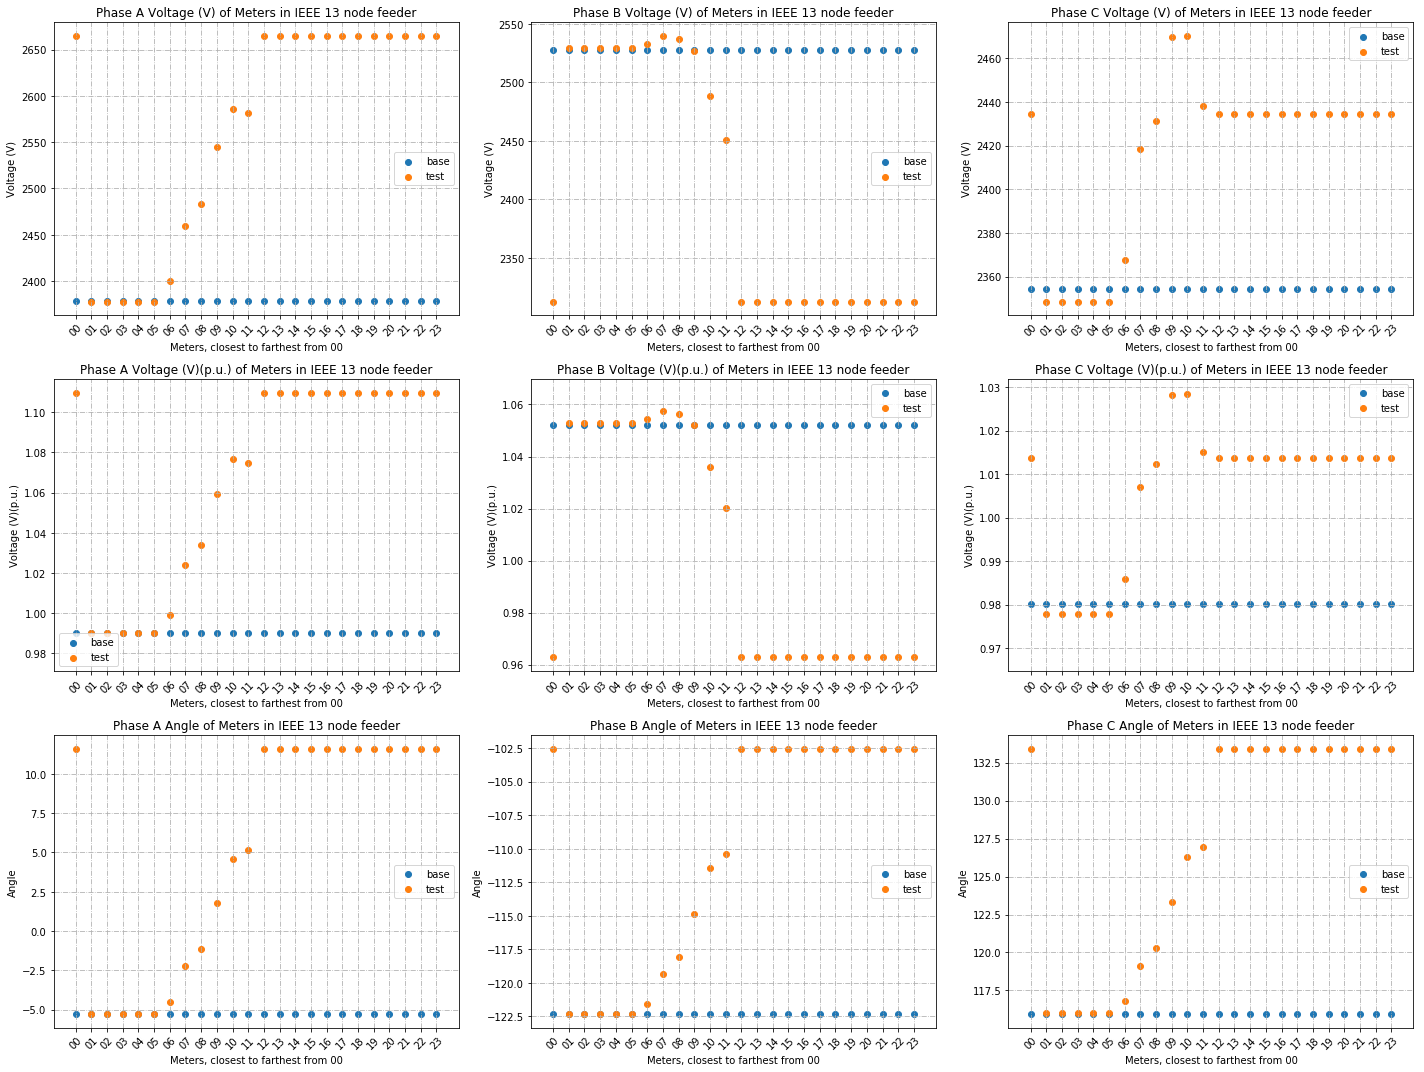

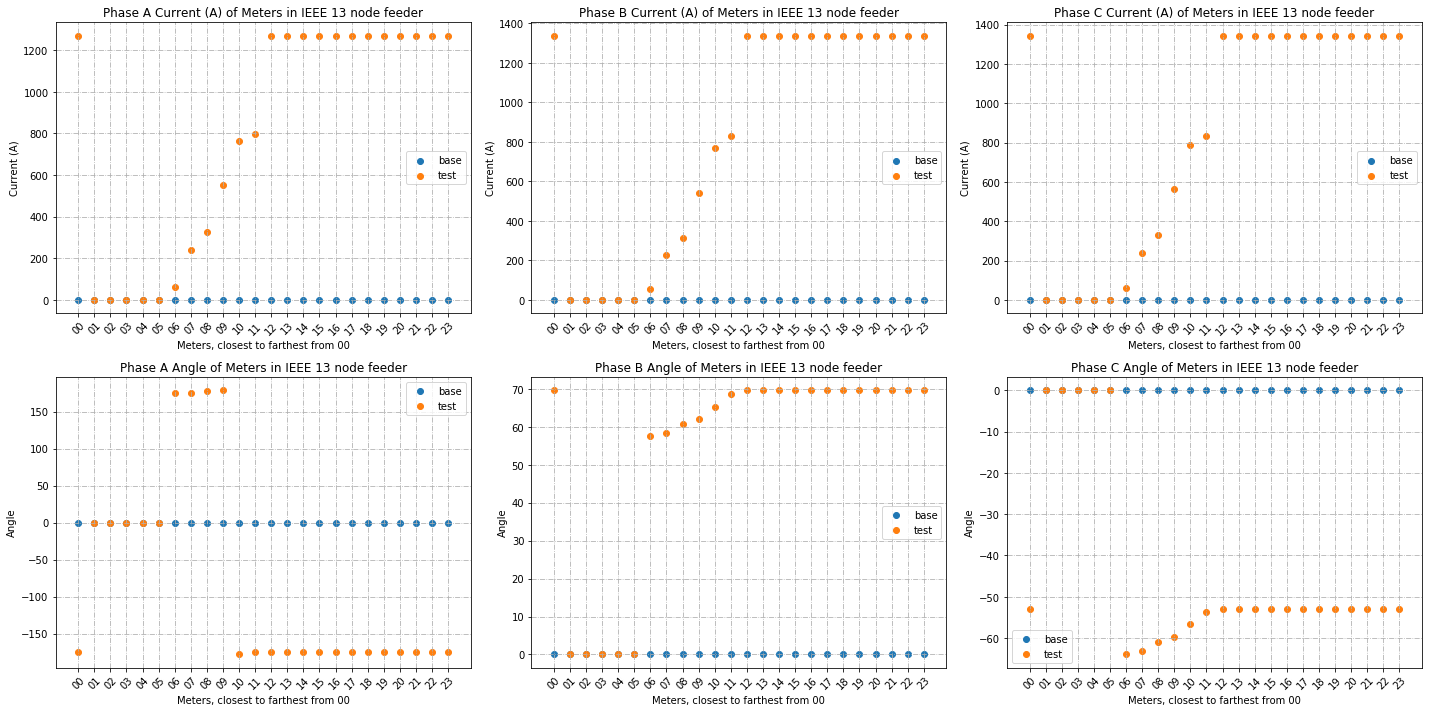

In [10]:
# compare pv before and after changes

compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         'Voltage_csv_pv_cmp_5',
                        'time_results/inverter_pv3.csv',
                            timestep=12,
                            phase_xml='IEEE13_pv3.xml', toggle_error=False)
compare_gridlab_inverter_csv_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                        ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         'Voltage_csv_pv_cmp_5',
                        'time_results/inverter_pv3.csv',
                            timestep=13,
                            phase_xml='IEEE13_pv3.xml', toggle_error=False)


compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_csv_pv_cmp_5',
                        timestep=12,
                        phase_xml="IEEE13_pv3.xml", toggle_error=False)
compare_gridlab_csv_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_csv_pv_cmp_5',
                        timestep=13,
                        phase_xml="IEEE13_pv3.xml", toggle_error=False)

compare_inverter_data_voltage(['time_results/voltageA_pv_control.csv',
                                      'time_results/voltageB_pv_control.csv',
                                      'time_results/voltageC_pv_control.csv'],
                         ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         filename='Voltage_inverter_pv_cmp5',
                            toggle_error=False)


compare_inverter_data_current(['time_results/measured_current_A_pv_control.csv',
                             'time_results/measured_current_B_pv_control.csv',
                             'time_results/measured_current_C_pv_control.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_inverter_pv_cmp5',
                        toggle_error=False)

# compare pv before and after changes

compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                         ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         'Voltage_csv_pv_cmp_6',
                        'time_results/inverter_pv3.csv',
                            timestep=12,
                            phase_xml='IEEE13_pv3.xml', toggle_error=False)
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                         ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         'Voltage_csv_pv_cmp_6',
                        'time_results/inverter_pv3.csv',
                            timestep=13,
                            phase_xml='IEEE13_pv3.xml', toggle_error=False)


compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_csv_pv_cmp_6',
                        timestep=12,
                        phase_xml="IEEE13_pv3.xml", toggle_error=False)
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_csv_pv_cmp_6',
                        timestep=13,
                        phase_xml="IEEE13_pv3.xml", toggle_error=False)

compare_inverter_data_voltage(['time_results/voltageA.csv',
                                      'time_results/voltageB.csv',
                                      'time_results/voltageC.csv'],
                         ['time_results/voltageA_pv3.csv',
                          'time_results/voltageB_pv3.csv',
                          'time_results/voltageC_pv3.csv'],
                         filename='Voltage_inverter_pv_cmp_6',
                            toggle_error=False)


compare_inverter_data_current(['time_results/measured_current_A.csv',
                             'time_results/measured_current_B.csv',
                             'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv3.csv',
                      'time_results/measured_current_B_pv3.csv',
                      'time_results/measured_current_C_pv3.csv'],
                      filename='Current_inverter_pv_cmp_6',
                        toggle_error=False)

In [ ]:
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                          'time_results/voltageB.csv',
                          'time_results/voltageC.csv'],
                        [ 'time_results/voltageA_pv_control.csv',
                          'time_results/voltageB_pv_control.csv',
                          'time_results/voltageC_pv_control.csv'],
                         'Voltage_csv_inverter_pv_control_2',
                        'time_results/inverter_pv.csv',
                            12,
                            phase_xml="IEEE13_pv_control.xml")
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                          'time_results/voltageB.csv',
                          'time_results/voltageC.csv'],
                        [ 'time_results/voltageA_pv_control.csv',
                          'time_results/voltageB_pv_control.csv',
                          'time_results/voltageC_pv_control.csv'],
                         'Voltage_csv_inverter_pv_control_2',
                        'time_results/inverter_pv.csv',
                            13,
                            phase_xml="IEEE13_pv_control.xml")

In [ ]:
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                          'time_results/voltageB.csv',
                          'time_results/voltageC.csv'],
                        ['time_results/voltageA_pv.csv',
                          'time_results/voltageB_pv.csv',
                          'time_results/voltageC_pv.csv'],
                         'Voltage_csv_inverter_mod_2',
                        'time_results/inverter_pv.csv',
                            12,
                            phase_xml='IEEE13_pv1.xml')
compare_gridlab_inverter_csv_voltage(['time_results/voltageA.csv',
                          'time_results/voltageB.csv',
                          'time_results/voltageC.csv'],
                        ['time_results/voltageA_pv.csv',
                          'time_results/voltageB_pv.csv',
                          'time_results/voltageC_pv.csv'],
                         'Voltage_csv_inverter_mod_2',
                        'time_results/inverter_pv.csv',
                            13,
                            phase_xml='IEEE13_pv1.xml')

In [ ]:
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                      'time_results/measured_current_B.csv',
                      'time_results/measured_current_C.csv'],
                    ['time_results/measured_current_A_pv_control.csv',
                     'time_results/measured_current_B_pv_control.csv',
                     'time_results/measured_current_C_pv_control.csv'],
                      filename='Current_csv_inverter_pv_control_2',
                        timestep=12,
                        phase_xml="IEEE13_pv_control.xml")
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                      'time_results/measured_current_B.csv',
                      'time_results/measured_current_C.csv'],
                    ['time_results/measured_current_A_pv_control.csv',
                     'time_results/measured_current_B_pv_control.csv',
                     'time_results/measured_current_C_pv_control.csv'],
                      filename='Current_csv_inverter_pv_control_2',
                        timestep=13,
                        phase_xml="IEEE13_pv_control.xml")

# also do an inverter voltage and current by time plot

In [ ]:
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                     'time_results/measured_current_B.csv',
                     'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv.csv',
                      'time_results/measured_current_B_pv.csv',
                      'time_results/measured_current_C_pv.csv'],
                      filename='Current_csv_inverter_mod_2',
                        timestep=-13,
                        phase_xml="IEEE13_pv1.xml")
compare_gridlab_csv_current(['time_results/measured_current_A.csv',
                     'time_results/measured_current_B.csv',
                     'time_results/measured_current_C.csv'],
                     ['time_results/measured_current_A_pv.csv',
                      'time_results/measured_current_B_pv.csv',
                      'time_results/measured_current_C_pv.csv'],
                      filename='Current_csv_inverter_mod_2',
                        timestep=-12,
                        phase_xml="IEEE13_pv1.xml")